This example is about inversion of ERT data around a hollow lime tree. It applies the BERT methodology of Günther et al. (2006) to trees, first documented by Göcke et al. (2008) and Martin & Günther (2013). The example has already been used in the BERT tutorial (Günther & Rücker, 2009-2023) in chapter 3.3 (closed geometries). The entire code is written in pyGIMLi (Rücker et al., 2017), using its ERT module.

In [45]:
# We first import the needed libraries, numpy, matplotlib,
# as well as pygimli and two of its modules.
import numpy as np
import matplotlib.pyplot as plt

import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

We first load in the data file and show its properties.

In [46]:
data = pg.load('hollow_limetree.ohm')
print(data)

Data: Sensors: 24 data: 264, nonzero entries: ['a', 'b', 'i', 'm', 'n', 'r', 'u', 'valid']


It uses 24 electrodes around the circumference and applies a dipole-dipole (AB-MN) array. For each of the 24 dipoles being used as current injection (AB), 21 potential dipoles (from 3-4 to 23-24) can be measured of which 10 are measured, so that we end up in a total of 24*11=264 measurements. Apart from current ('a' and 'b') and potential ('m', 'n') electrodes, the data files contains current ('i'), voltage ('u') and resistance ('r') vectors for each of the 264 data.

We first generate the geometry by creating a polygon with a function from the meshtools.

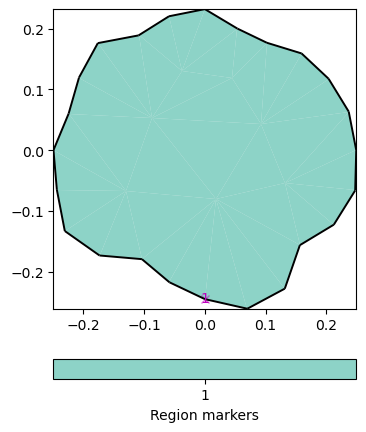

In [47]:
plc = mt.createPolygon(data.sensors(), isClosed=True)
pg.show(plc);

From this geometry, we create a triangular mesh with a quality factor, a maximum triangle area and post-smoothing.

Mesh: Nodes: 884 Cells: 1672 Boundaries: 2555


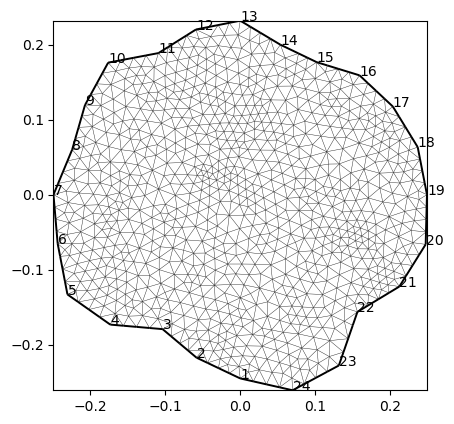

In [48]:
mesh = mt.createMesh(plc, quality=34.3, area=2e-4, smooth=[10, 1])
print(mesh)
ax, _ = pg.show(mesh)
for i, s in enumerate(data.sensors()):
    ax.text(s.x(), s.y(), str(i+1), zorder=100)

We first create the geometric factors to multiply the resistances to obtain "mean" resistivities for every quadrupol. We do this numerically using a refined mesh with quadratic shape functions using a constant resistivity of 1. The inverse of the modelled resistances is the geometric factor so that all apparent resistivities become 1.
We then generate the apparent resistivity, store it in the data container and display it.

19/01/24 - 14:07:36 - pyGIMLi - INFO - Save RVector binary
19/01/24 - 14:07:36 - pyGIMLi - INFO - Cache stored: C:\Guenther.T\Anwendungsdaten\pygimli\Cache\14417697841682099605


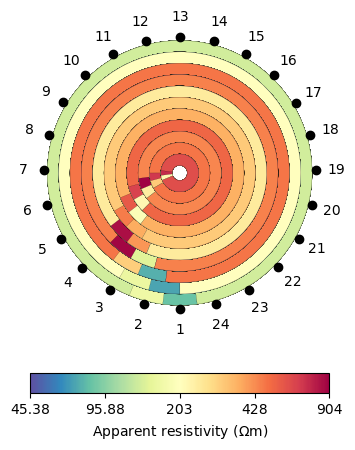

In [49]:
data["k"] = ert.createGeometricFactors(data, mesh=mesh, numerical=True)
data["rhoa"] = data["r"] * data["k"]
ert.show(data, "rhoa", circular=True);

It has almost circular behaviour, with lower values for shallow penetrations and higher ones for larger current-voltage distances.

We estimate a measuring error using default values (3% plus 100µV) and feed it into the ERT Manager.

In [50]:
data.estimateError()
mgr = ert.Manager(data)
mgr.invert(mesh=mesh, verbose=True)

19/01/24 - 14:07:36 - pyGIMLi - INFO - Found 1 regions.
19/01/24 - 14:07:36 - pyGIMLi - INFO - Creating forward mesh from region infos.
19/01/24 - 14:07:36 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
19/01/24 - 14:07:36 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 3439 Cells: 6688 Boundaries: 5110
19/01/24 - 14:07:36 - pyGIMLi - INFO - Use median(data values)=201.94146645684552
19/01/24 - 14:07:36 - pyGIMLi - INFO - Created startmodel from forward operator: 1672, min/max=201.941466/201.941466
19/01/24 - 14:07:36 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000259CC06D040>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x00000259CC06D180>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000259CC06D0E0>
min/max (data): 45.38/904
min/max (error): 3%/3%
min/max (start model): 202/202
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  381.60
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   70.36 (dPhi = 80.42%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    2.97 (dPhi = 89.68%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    2.04 (dPhi = 9.22%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    2.03 (dPhi = 0.33%) lam: 20.0
####################

1672 [162.55375323691229,...,220.84968703192496]

We achieve a fairly good data fit with a chi-square value of 2 and compare data and model response.

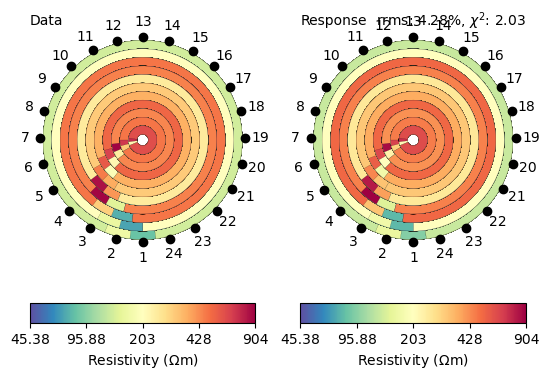

In [51]:
mgr.showFit(circular=True);

Both look very similar. Therefore we explicitly look at the misfit.

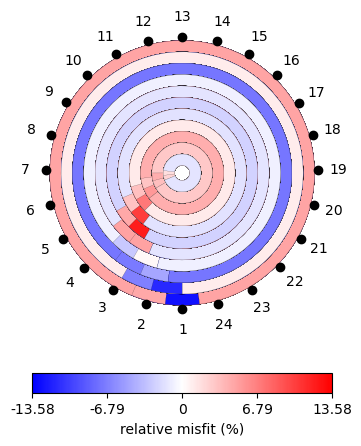

In [52]:
mgr.showMisfit(circular=True);

There is definitely some systematic misfit that could have been caused by small-scale anomalies, insufficient discretization, or inaccurate geometric description.
Finally, we have a look at the resulting resistivity distribution.

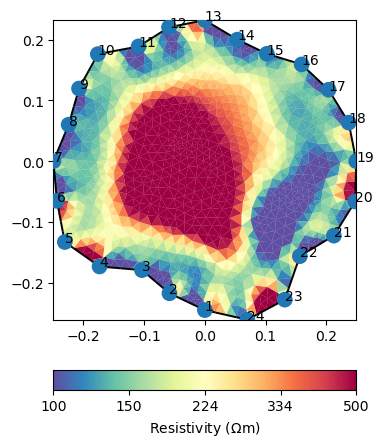

In [53]:
ax, cb = mgr.showResult(cMin=100, cMax=500, coverage=1)
for i, s in enumerate(data.sensors()):
    ax.text(s.x(), s.y(), str(i+1), zorder=100)

For comparison, we have a look at the section photograph.

![A cross-section of the hollow lime tree](hollow_limetree.jpg)

## References
* Günther, T., Rücker, C. & Spitzer, K. (2006): Three-dimensional modeling and inversion of dc resistivity data incorporating topography – II: Inversion. Geophys. J. Int. 166, 506-517, [doi:10.1111/j.1365-246X.2006.03011.x](https://doi.org/10.1111/j.1365-246X.2006.03011.x).
* Göcke, L., Rust, S., Weihs, U., Günther, T. & Rücker, C. (2008): Combining sonic and electrical impedance tomography for the nondestructive testing of trees. - Western Arborist, Spring/2008: 1-11.
* Martin, T. & Günther, T. (2013): Complex Resistivity Tomography (CRT) for fungus detection on standing oak trees. European Journal of Forest Research 132(5), 765-776, [doi:10.1007/s10342-013-0711-4](https://doi.org/10.1007/s10342-013-0711-4).
* Rücker, C., Günther, T., Wagner, F.M. (2017): pyGIMLi: An open-source library for modelling and inversion in geophysics, Computers & Geosciences 109, 106-123, [doi:10.1016/j.cageo.2017.07.011](https://doi.org/10.1016/j.cageo.2017.07.011).